In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

# System libraries
from pathlib import Path
import os.path
import os 

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('darkgrid')

# EfficientNetB0 Model

In [ ]:
dataset_path = "/kaggle/input/sea-animals-image-dataste/"

In [3]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

- bash command for loading extra functions (helper function) we will declare it next

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-12-07 09:46:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-12-07 09:46:18 (53.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, walk_through_dir

dataset = "../input/sea-animals-image-dataste"
walk_through_dir(dataset)

There are 23 directories and 0 images in '../input/sea-animals-image-dataste'.
There are 0 directories and 482 images in '../input/sea-animals-image-dataste/Penguin'.
There are 0 directories and 497 images in '../input/sea-animals-image-dataste/Clams'.
There are 0 directories and 499 images in '../input/sea-animals-image-dataste/Lobster'.
There are 0 directories and 500 images in '../input/sea-animals-image-dataste/Otter'.
There are 0 directories and 497 images in '../input/sea-animals-image-dataste/Eel'.
There are 0 directories and 500 images in '../input/sea-animals-image-dataste/Corals'.
There are 0 directories and 531 images in '../input/sea-animals-image-dataste/Puffers'.
There are 0 directories and 483 images in '../input/sea-animals-image-dataste/Squid'.
There are 0 directories and 572 images in '../input/sea-animals-image-dataste/Whale'.
There are 0 directories and 579 images in '../input/sea-animals-image-dataste/Sea Urchins'.
There are 0 directories and 499 images in '../inpu

In [6]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2, 
    shuffle=True,
    subset="training",
    seed=42,
    image_size=(224, 224),
    batch_size=32)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1, 
    shuffle=True,
    subset="validation", 
    seed=42,
    image_size=(224, 224),
    batch_size=32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,  
    shuffle=True,
    subset="validation", 
    seed=42,
    image_size=(224, 224),
    batch_size=32)

Found 13711 files belonging to 23 classes.
Using 10969 files for training.
Found 13711 files belonging to 23 classes.
Using 1371 files for validation.
Found 13711 files belonging to 23 classes.
Using 1371 files for validation.


In [ ]:
from pathlib import Path

image_dir = Path(dataset) 

filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.PNG'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

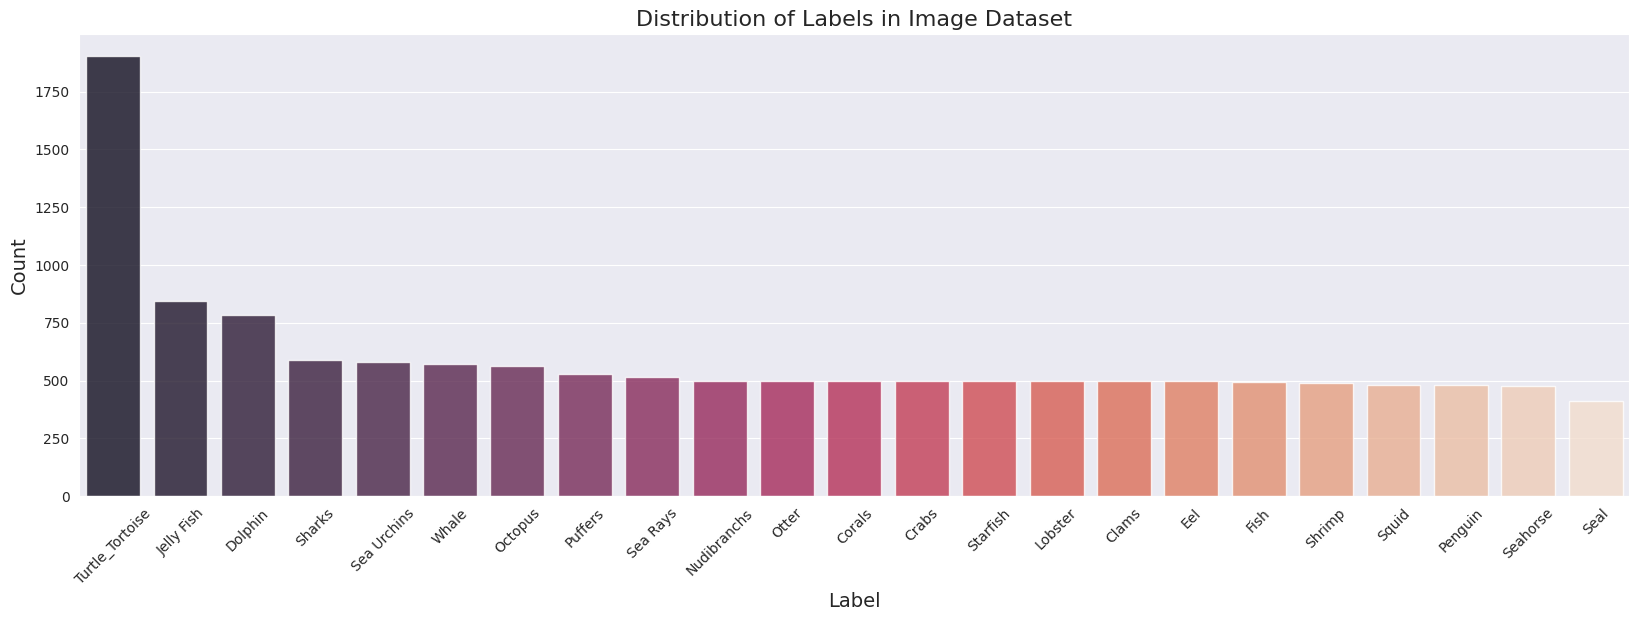

In [8]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

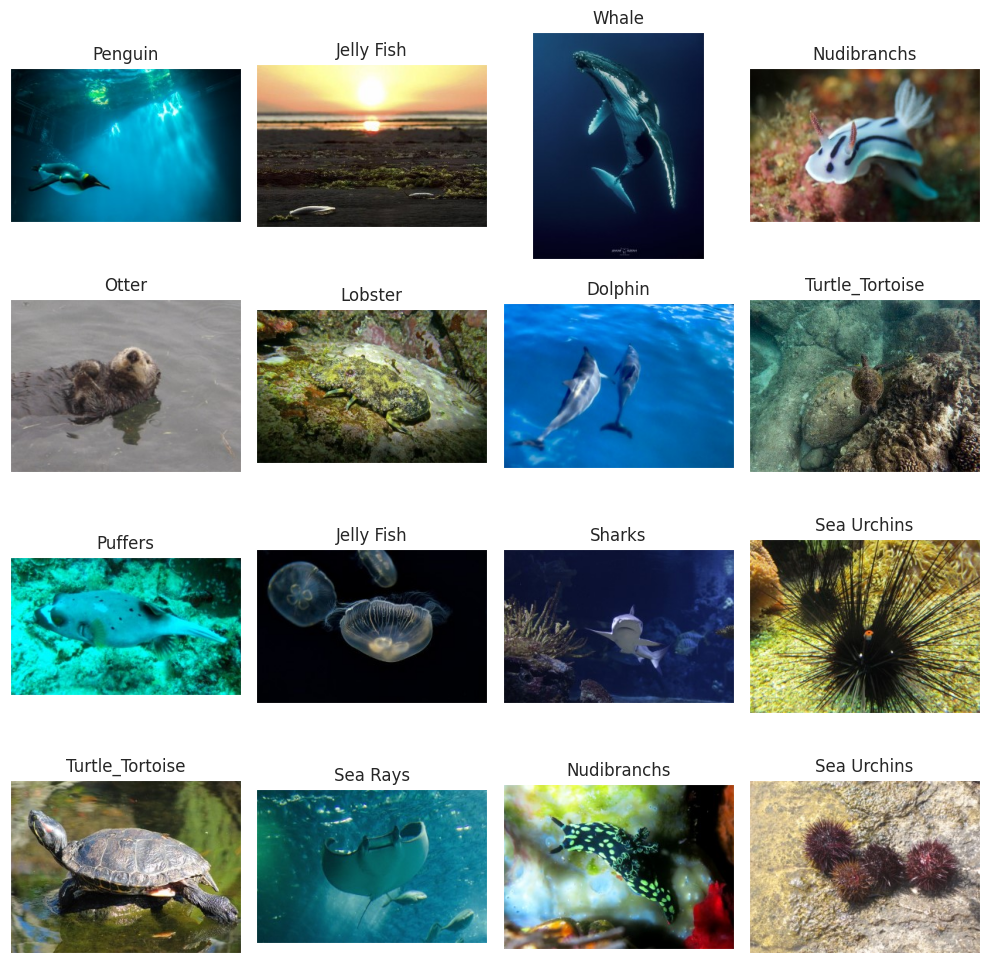

In [ ]:

random_index = np.random.randint(0, len(image_df), 16)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [11]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [12]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 8775 validated image filenames belonging to 23 classes.
Found 2193 validated image filenames belonging to 23 classes.
Found 2743 validated image filenames belonging to 23 classes.


In [13]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Clams', 'Corals', 'Crabs', 'Dolphin', 'Eel', 'Fish', 'Jelly Fish', 'Lobster', 'Nudibranchs', 'Octopus', 'Otter', 'Penguin', 'Puffers', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Seal', 'Sharks', 'Shrimp', 'Squid', 'Starfish', 'Turtle_Tortoise', 'Whale']


In [ ]:
# Data Augmentation 
augment = tf.keras.Sequential([
    layers.Resizing(224, 224),                    
    layers.Rescaling(1./255),                     
    layers.RandomFlip("horizontal"),              
    layers.RandomRotation(0.1),                   
    layers.RandomZoom(0.1),                      
    layers.RandomContrast(0.1),                   
])

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [16]:
checkpoint_path = "animals_classification_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [ ]:

inputs = pretrained_model.input

x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)

x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)

outputs = Dense(23, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer=Adam(0.00001),
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        create_tensorboard_callback("training_logs", "animal_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/animal_classification/20251207-094725
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.0556 - loss: 5.0363

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.19106, saving model to animals_classification_model_checkpoint.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 212s 516ms/step - accuracy: 0.0557 - loss: 5.0327 - val_accuracy: 0.1911 - val_loss: 2.8258
Epoch 2/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.1233 - loss: 3.0655
Epoch 2: val_accuracy improved from 0.19106 to 0.33835, saving model to animals_classification_model_checkpoint.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 57s 205ms/step - accuracy: 0.1233 - loss: 3.0653 - val_accuracy: 0.3383 - val_loss: 2.6014
Epoch 3/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.1739 - loss: 2.8539
Epoch 3: val_accuracy improved from 0.33835 to 0.40720, saving model to animals_classification_model_checkpoint.weights.h5
275/275 ━━━━━━━━━━━━━━━━━━━━ 57s 205ms/step - accuracy: 0.1739 - loss: 2.8538 - val_accuracy: 0.4072 - val_loss: 2.4257
Epoch 4/100
275/275 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2119 - loss: 2.7354
Epoch

In [ ]:
# model.save("sea_animals_model_100.keras")

In [22]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.80050
Test Accuracy: 77.03%


In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
len(accuracy)

100

In [ ]:
epochs = len(accuracy)
epochs

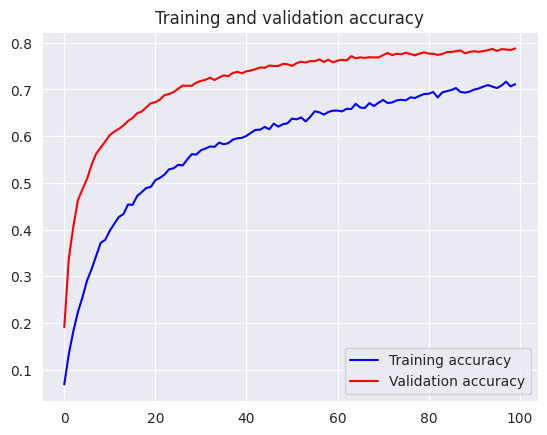

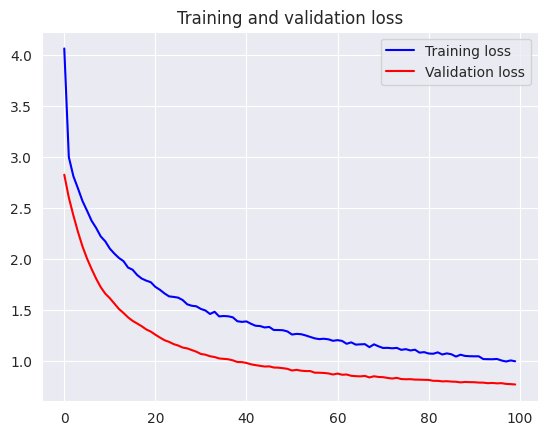

In [25]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images) 
pred = np.argmax(pred,axis=1) 


labels = (train_images.class_indices) 
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}') # هنا كنت بشوف اول خمسه بريديكشن مش اكتر الكود شغال ولا لا

86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 315ms/step
The first 5 predictions: ['Corals', 'Jelly Fish', 'Jelly Fish', 'Turtle_Tortoise', 'Eel']


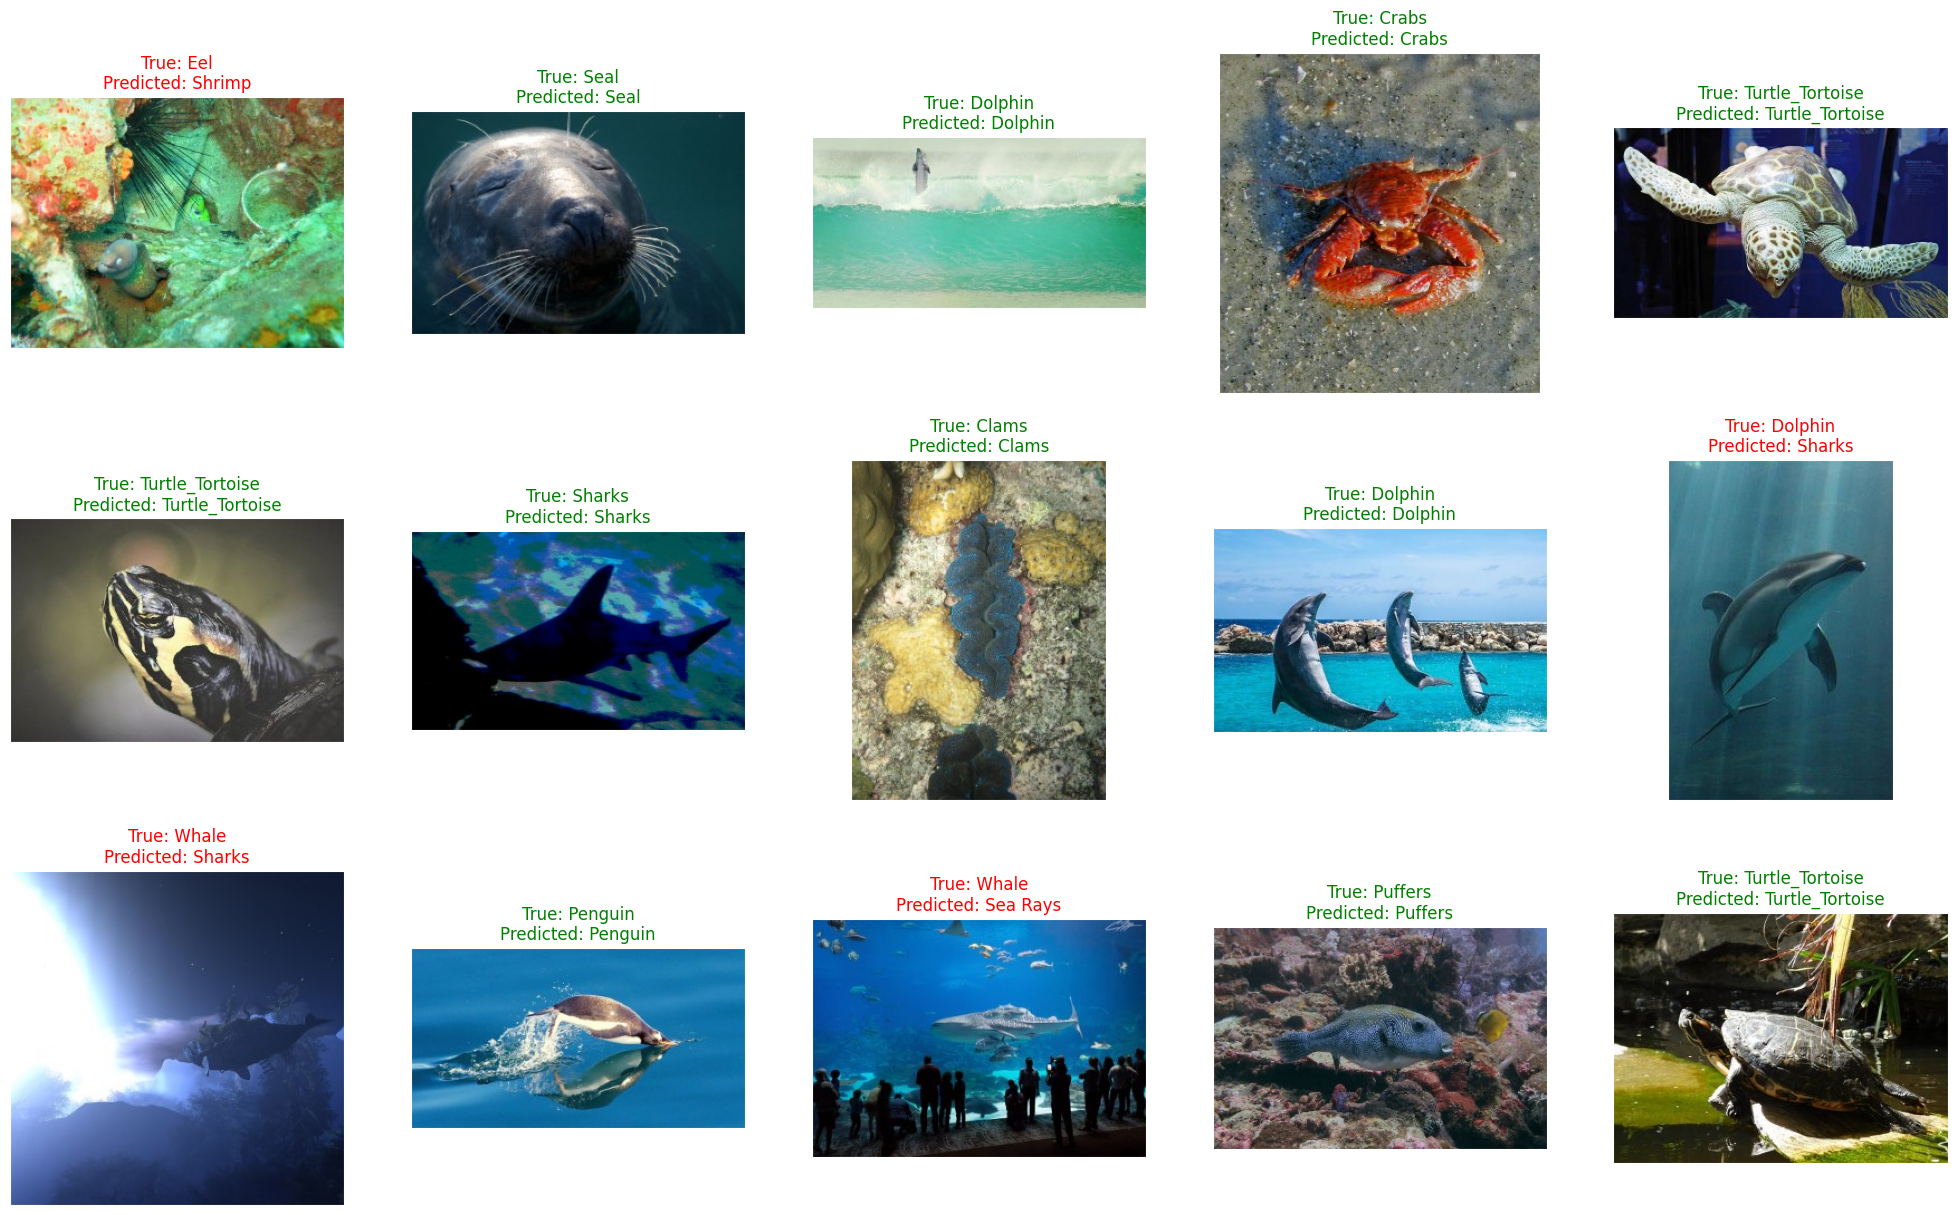

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green" 
    else:
      color = "red" 
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [28]:
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

                 precision    recall  f1-score   support

          Clams       0.61      0.52      0.56       101
         Corals       0.45      0.76      0.56        91
          Crabs       0.91      0.95      0.92        91
        Dolphin       0.72      0.79      0.75       155
            Eel       0.68      0.70      0.69       105
           Fish       0.72      0.63      0.67       100
     Jelly Fish       0.87      0.97      0.92       173
        Lobster       0.76      0.70      0.73       100
    Nudibranchs       0.69      0.67      0.68        94
        Octopus       0.57      0.52      0.55       119
          Otter       0.97      0.98      0.97        96
        Penguin       0.88      0.74      0.80       108
        Puffers       0.88      0.71      0.79       118
       Sea Rays       0.75      0.71      0.73       104
    Sea Urchins       0.94      0.99      0.96       109
       Seahorse       0.76      0.64      0.70       114
           Seal       0.91    

In [29]:
report = classification_report(y_test, pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score      support
Clams             0.609195  0.524752  0.563830   101.000000
Corals            0.448052  0.758242  0.563265    91.000000
Crabs             0.905263  0.945055  0.924731    91.000000
Dolphin           0.719298  0.793548  0.754601   155.000000
Eel               0.675926  0.695238  0.685446   105.000000
Fish              0.715909  0.630000  0.670213   100.000000
Jelly Fish        0.874346  0.965318  0.917582   173.000000
Lobster           0.760870  0.700000  0.729167   100.000000
Nudibranchs       0.692308  0.670213  0.681081    94.000000
Octopus           0.574074  0.521008  0.546256   119.000000
Otter             0.969072  0.979167  0.974093    96.000000
Penguin           0.879121  0.740741  0.804020   108.000000
Puffers           0.884211  0.711864  0.788732   118.000000
Sea Rays          0.747475  0.711538  0.729064   104.000000
Sea Urchins       0.939130  0.990826  0.964286   109.000000
Seahorse          0.760417  0.640351  0.695238   114.000000
Seal              0.911392  0.808989  0.857143    89.000000
Sharks            0.661654  0.814815  0.730290   108.000000
Shrimp            0.597826  0.539216  0.567010   102.000000
Squid             0.685393  0.663043  0.674033    92.000000
Starfish          0.932584  0.965116  0.948571    86.000000
Turtle_Tortoise   0.905263  0.945055  0.924731   364.000000
Whale             0.660194  0.548387  0.599119   124.000000
accuracy          0.770324  0.770324  0.770324     0.770324
macro avg         0.761260  0.750543  0.751848  2743.000000
weighted avg      0.775344  0.770324  0.769257  2743.000000

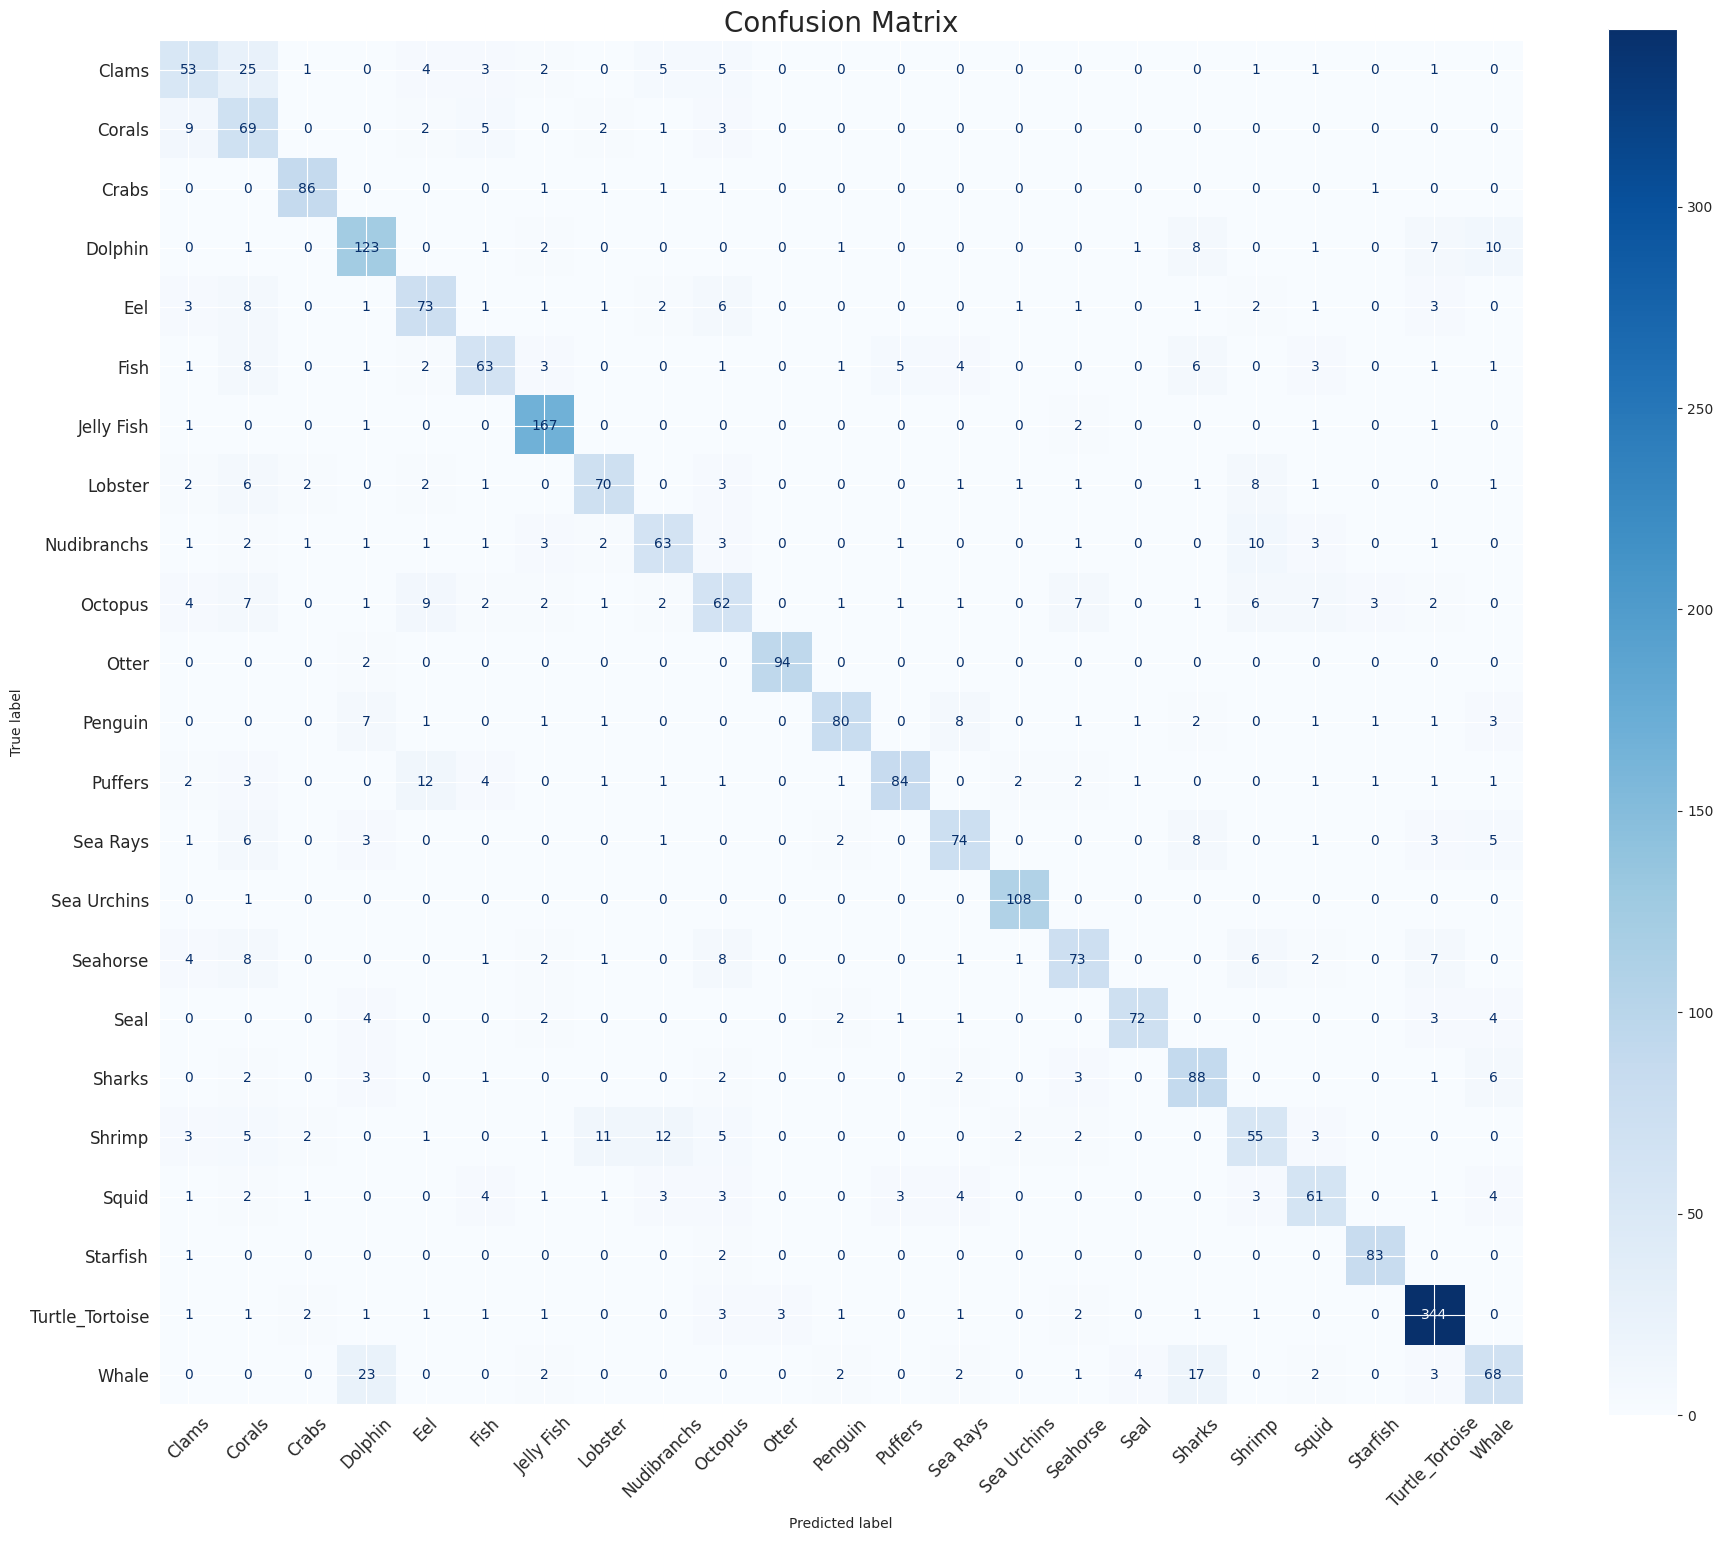

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, pred)

fig, ax = plt.subplots(figsize=(22, 18))  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels.values()))
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax)

plt.title("Confusion Matrix", fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()